In [1]:
import sys, os
sys.path.append(os.path.dirname(os.path.join((os.path.pardir), "Modules")))

origin_dir = os.path.join(os.path.pardir, 'Data')


new_dir_path = os.path.join(os.path.pardir, 'Datasets')

true_parasitized_path = os.path.relpath("corrected_images/True_parasitized.csv")
false_parasitized_path = os.path.relpath("corrected_images/False_parasitized.csv")
true_uninfected_path = os.path.relpath("corrected_images/True_uninfected.csv")
false_uninfected_path = os.path.relpath("corrected_images/False_uninfected.csv")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler as scaler

### **RUN THE BELOW CELL IF USING COLAB** (overrides paths and installs packages)

For the git clone segment, please add the Personal Access Token instead of the {pat} segment 

In [3]:
# # RUN THIS CELL IF COLAB

# !pip3 install tsnecuda==3.0.1+cu113 -f https://tsnecuda.isx.ai/tsnecuda_stable.html

# from tsnecuda import TSNE

# from google.colab import drive

# drive.mount('/content/gdrive')
# !git clone "https://{pat}@github.com/madhava20217/Malaria-Detection-from-Cells.git"

# !pip install -q -r "/content/Malaria-Detection-from-Cells/requirements_versionless.txt" 

# sys.path.append(os.path.dirname('/content/Malaria-Detection-from-Cells/Modules'))
# origin_dir = "/content/Data"
# new_dir_path = "/content/Datasets/"

# true_parasitized_path  = '/content/Malaria-Detection-from-Cells/EDA/corrected_images/True_parasitized.csv'
# false_parasitized_path = '/content/Malaria-Detection-from-Cells/EDA/corrected_images/False_parasitized.csv'
# true_uninfected_path   = '/content/Malaria-Detection-from-Cells/EDA/corrected_images/True_uninfected.csv'
# false_uninfected_path  = '/content/Malaria-Detection-from-Cells/EDA/corrected_images/False_uninfected.csv'


### Run this cell if you want to download data and label the datapoints

In [4]:
# from Modules.data_download import Data_Download
# from Modules.labelling import Labelling

# download = Data_Download(origin_dir)

In [5]:
parasitized_dir = os.path.join(origin_dir, 'cell-images-for-detecting-malaria', 'cell_images', "Parasitized")
uninfected_dir  = os.path.join(origin_dir, 'cell-images-for-detecting-malaria', 'cell_images', 'Uninfected')

true_parasitized = pd.read_csv(true_parasitized_path, index_col = 0, names = ['ImagePath'], header = 0)
false_parasitized = pd.read_csv(false_parasitized_path, index_col = 0, names = ['ImagePath'], header = 0)

true_uninfected = pd.read_csv(true_uninfected_path, index_col = 0, names = ['ImagePath'], header = 0)
false_uninfected = pd.read_csv(false_uninfected_path, index_col = 0, names = ['ImagePath'], header = 0)

## Data Import

## Modifying File Paths in DataFrames to point to images

In [6]:
for dataset in [true_parasitized, false_parasitized]:
    dataset['ImagePath'] = dataset['ImagePath'].apply(lambda row: os.path.join(parasitized_dir, row))

for dataset in [true_uninfected, false_uninfected]:
    dataset['ImagePath'] = dataset['ImagePath'].apply(lambda row: os.path.join(uninfected_dir, row))

## Visualising Images

### Labelling

In [7]:
true_parasitized['status'] = 'true_parasitized'
false_parasitized['status'] = 'false_parasitized'

true_uninfected['status'] = 'true_uninfected'
false_uninfected['status'] = 'false_uninfected'

#joining the dataframes
images = pd.concat([true_parasitized, false_parasitized, true_uninfected, false_uninfected])
images.reset_index(drop = True, inplace = True)

### Function to read a single image given the path

In [8]:
def read_image(path, resize = False, width = 50, height = 50, IMAGE_MODE = 1):
    '''Reads and loads images into a numpy array
    Returns: a numpy array
    
    Arguments:
    
    1. path_arr: array containing paths to the images
    2. resize: whether to resize the image
    3. width : width of the resized image
    4. height: height of the resized image
    5 . IMAGE_MODE: the state of the images - 1 for Colour, 0 for GrayScale, as per opencv2 documentation'''

    image = cv2.imread(path, IMAGE_MODE)
    if resize:
        image = cv2.resize(image, (width, height))
    
    return image

### Visualising Color: TODO

What to do here?

- Plot images of the various classes (true_uninfected, true_parasitized, false_uninfected, false_parasitized) 
- Randomly choose 8 images with no replacement from each class. Use the following dataframes:
  - true_parasitized
  - false_parasitized
  - true_uninfected
  - false_uninfected

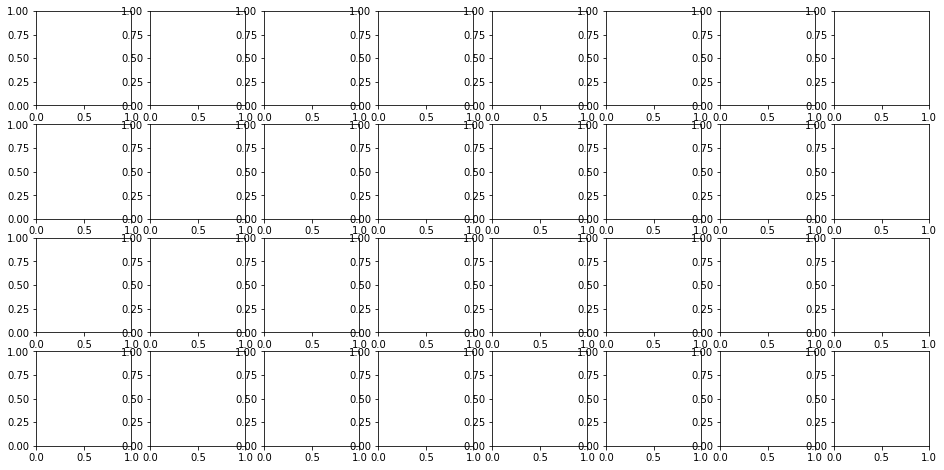

In [9]:
#TODO:  EDA

figs, axes = plt.subplots(4, 8, figsize = (16, 8))

### Red Dimension: TODO

The same as above, but visualise the R dimension of each image

### Blue Dimension: TODO

The same as above, but visualise the B dimension of each image

### Green Dimension: TODO

The same as above, but visualise the G dimension of each image

### Grayscale: TODO

The same as above, but visualise each image as grayscale

## Clustering and Visualisation using TSNE

### Function for loading images as a numpy array

In [10]:
def load_images(path_arr, resize = True, width = 50, height = 50, IMAGE_MODE = 1):
    '''Reads and loads images into a numpy array
    Returns: a numpy array
    
    Arguments:
    
    1. path_arr: array containing paths to the images
    2. resize: whether to resize the image
    3. width : width of the resized image
    4. height: height of the resized image
    5 . IMAGE_MODE: the state of the images - 1 for Colour, 0 for GrayScale, as per opencv2 documentation'''
    
    arr = []
    for path in path_arr:
        resized = cv2.imread(path, IMAGE_MODE)
        if resize:
            resized = cv2.resize(resized, (width, height))
        arr.append(resized)
    return np.array(arr)

### Data Loading

Here, we resize the images so that the distances can be measured without issues.

In [11]:
images.ImagePath[0]

'..\\Data\\cell-images-for-detecting-malaria\\cell_images\\Parasitized\\C39P4thinF_original_IMG_20150622_105253_cell_94.png'

In [12]:
#resizing using 
h = 50
w = 50

image_array = load_images(images.ImagePath.to_numpy(), resize = True, height = 50, width = 50)/255.0

print(image_array.shape)


(27558, 50, 50, 3)


In [13]:
dims = image_array.shape[1:]
shape = 1
for x in dims:
    shape*=x

image_array = image_array.reshape((image_array.shape[0], shape))
print(image_array.shape)

(27558, 7500)


In [14]:
image_array[0].shape

(7500,)

### Reducing dimensions and visualising using TSNE

In [15]:
#TODO with GPU

tsne = TSNE(
    n_components = 2,
    perplexity = 100,
    n_iter = 1000,
    metric = 'euclidean',
    verbose = 2,
)

coords = tsne.fit_transform(image_array)

fit_df = pd.DataFrame(coords)
fit_df.columns = ['x', 'y']
fit_df['label'] = images['status']

C:\Users\krish\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\krish\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 27558 samples in 0.180s...
[t-SNE] Computed neighbors for 27558 samples in 35.437s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27558
[t-SNE] Computed conditional probabilities for sample 2000 / 27558
[t-SNE] Computed conditional probabilities for sample 3000 / 27558
[t-SNE] Computed conditional probabilities for sample 4000 / 27558
[t-SNE] Computed conditional probabilities for sample 5000 / 27558
[t-SNE] Computed conditional probabilities for sample 6000 / 27558
[t-SNE] Computed conditional probabilities for sample 7000 / 27558
[t-SNE] Computed conditional probabilities for sample 8000 / 27558
[t-SNE] Computed conditional probabilities for sample 9000 / 27558
[t-SNE] Computed conditional probabilities for sample 10000 / 27558
[t-SNE] Computed conditional probabilities for sample 11000 / 27558
[t-SNE] Computed conditional probabilities for sample 12000 / 27558
[t-SNE] Computed conditional probabilities for s

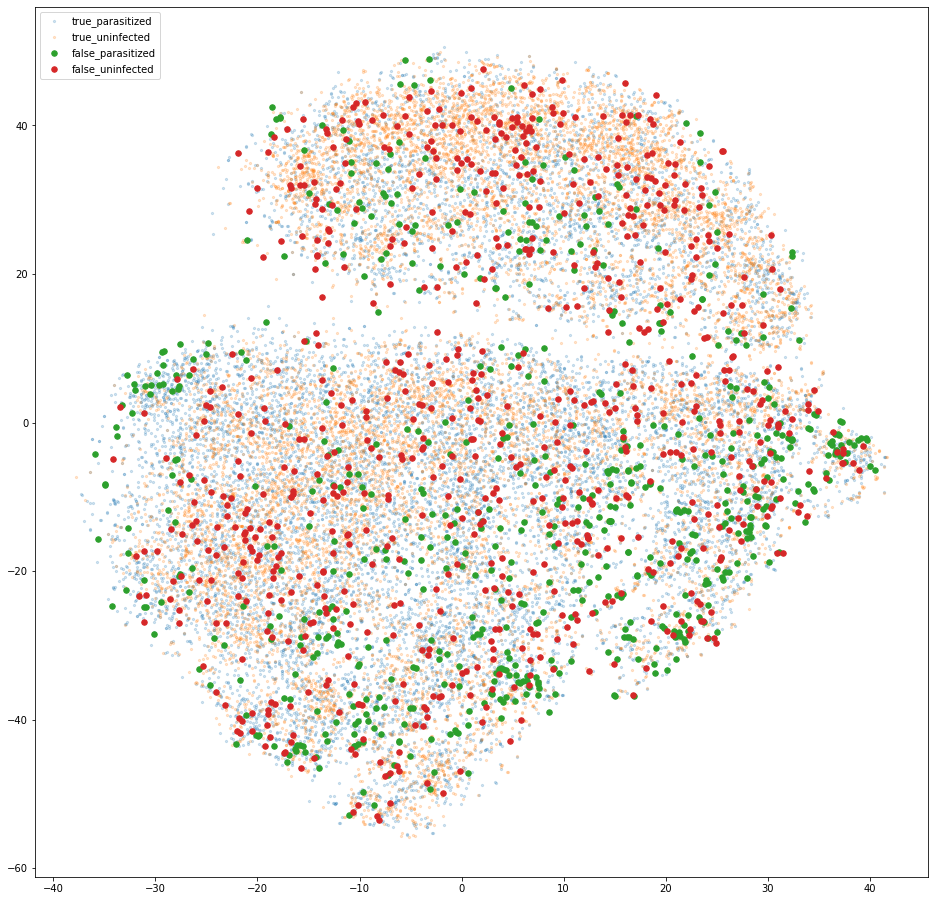

In [16]:
plt.figure(figsize = (16, 16))


for val in ['true_parasitized', 'true_uninfected']:
    plt.scatter(fit_df[fit_df.label == val].x, 
                fit_df[fit_df.label == val].y,
                s = 5,
                alpha = 0.2,
                label = val)

for val in ['false_parasitized', 'false_uninfected']:
    plt.scatter(fit_df[fit_df.label == val].x, 
                fit_df[fit_df.label == val].y,
                s = 30,
                alpha = 1,
                label = val)

plt.legend(loc = 'upper left')

### Clustering : TODO

### TODO: EDA again with the reduced dataset :(